In [6]:
import Environment
import Shop
from mab.ts_learner import *
from mab.ucb_learner import *
from utilities import *

In this setting we have three shops:
1. **Clairvoyant**: which just naively tests all permutations of possible prices and picks the best one
2. **TS**: which learns the best possible price using Thompson Sampling.
3. **UCB**: which learns the best possible price using Upper Confidence Bound.

The shops are assumed to know everything except for the price of the first item.

In [7]:
shop_ts = Shop.Shop()
shop_ucb = Shop.Shop()
shop_clairvoyant = Shop.Shop()

print(shop_ts.prices1)
print(shop_ts.prices2)

env = Environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

# The environment decides the conversion rates, which are shared among all the shops.
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(env.true_conv1,env.true_conv2)
shop_ucb.set_conv_rate(env.true_conv1, env.true_conv2)

#Initialize learners
shop_ts.set_price_learner('TS')
shop_ucb.set_price_learner('UCB')


[ 80. 200. 360. 560. 800.]
[ 100.  250.  450.  700. 1000.]


In [8]:
days = 365

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []

for day in range(days):
    #Generating customers for the next day
    env.generate_next_day_customers()
    
    #Every shop knows how many customers are coming
    shop_clairvoyant.set_expected_customers(env.customers)
    shop_ts.set_expected_customers(env.customers)
    shop_ucb.set_expected_customers(env.customers)

    #Pull arm from learners 
    chosen_price_ts = shop_ts.price_learner.pull_arm(shop_ts.customers)
    chosen_price_ucb = shop_ucb.price_learner.pull_arm() 

    #Calculate the best promos for the current pulled arms
    shop_clairvoyant.best_promo_per_class()
    shop_ts.best_promo_per_class(chosen_price_ts)
    shop_ucb.best_promo_per_class(chosen_price_ucb)
    
    #Shuffle customers and unroll customers and coupons array
    shop_clairvoyant.print_coupons()
    shop_ts.print_coupons()
    shop_ucb.print_coupons()
    
    clairvoyant_per_class = []
    revenue_ts = []
    revenue_ucb = []
    
    np.random.shuffle(shop_ts.customers_random)

    #print(shop_ts.prices2)
    #print(shop_ts.best_price[1])

    for cust in shop_ts.customers_random:
        partial_revenue = 0
        cust = int(cust)
        #Check if first item has been bought and update the parameters

        ## WHY DO WE USE BEST PRICE INSTEAD OF PULLED ARM????
        ts_has_bought1 = env.round1(cust, shop_ts.best_price[0])
        shop_ts.price_learner.update(chosen_price_ts, ts_has_bought1, cust)

        ucb_has_bought1 = env.round1(cust, shop_ucb.best_price[0])
        shop_ucb.price_learner.update(chosen_price_ucb, ucb_has_bought1, cust)
        
        partial_revenue_ts = ts_has_bought1*shop_ts.best_price[0]
        partial_revenue_ucb = ucb_has_bought1*shop_ucb.best_price[0]

        #Check if second item has been bought
        if ts_has_bought1 == 1:
            ts_has_bought2 = env.round2(cust, shop_ts.matched_promos[cust], shop_ts.best_price[1])
            partial_revenue_ts += ts_has_bought2*shop_ts.best_price[1]*(1-shop_ts.discounts[shop_ts.matched_promos[cust]])
        revenue_ts.append(partial_revenue_ts)
        
        if ucb_has_bought1 == 1:
            ucb_has_bought2 = env.round2(cust, shop_ucb.matched_promos[cust], shop_ucb.best_price[1])
            partial_revenue_ucb += ucb_has_bought2*shop_ucb.best_price[1]*(1-shop_ucb.discounts[shop_ucb.matched_promos[cust]])
        revenue_ucb.append(partial_revenue_ucb)

        expected_revenue = shop_clairvoyant.best_price[0]*env.true_conv1[cust, index(env.prices1, shop_clairvoyant.best_price[0])] + env.true_conv1[cust, index(env.prices1, shop_clairvoyant.best_price[0])]*env.true_conv2[cust, shop_clairvoyant.matched_promos[cust], index(env.prices2, shop_clairvoyant.best_price[1])]*shop_clairvoyant.best_price[1]*(1-shop_clairvoyant.discounts[shop_clairvoyant.matched_promos[cust]])
        clairvoyant_per_class.append(expected_revenue)
    
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(clairvoyant_per_class))


In [10]:
len(ts_rewards_per_class_per_day)

365

Text(0, 0.5, 'Revenue')

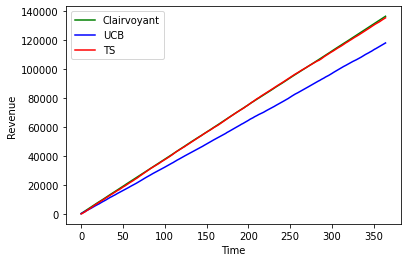

In [4]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(u_rewards_per_class_per_day),color='blue',label='UCB')
plt.plot(np.cumsum(ts_rewards_per_class_per_day),color='red',label = 'TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

#plt.yscale('symlog')


In [5]:
shop_ts.price_learner.pull_arm(shop_ts.customers)

(2,)

Text(0, 0.5, 'Regret')

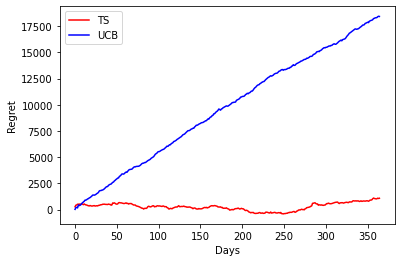

In [9]:
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')